# Blog 7: Failure Prediction with Vibration + LSTM

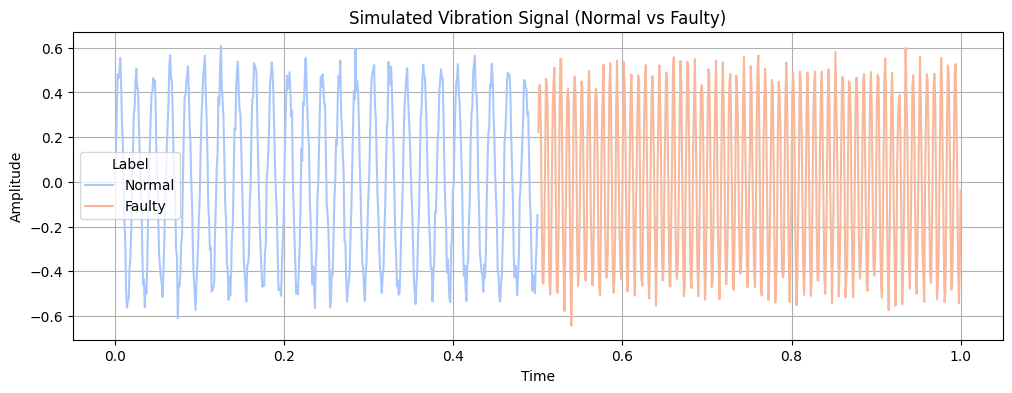

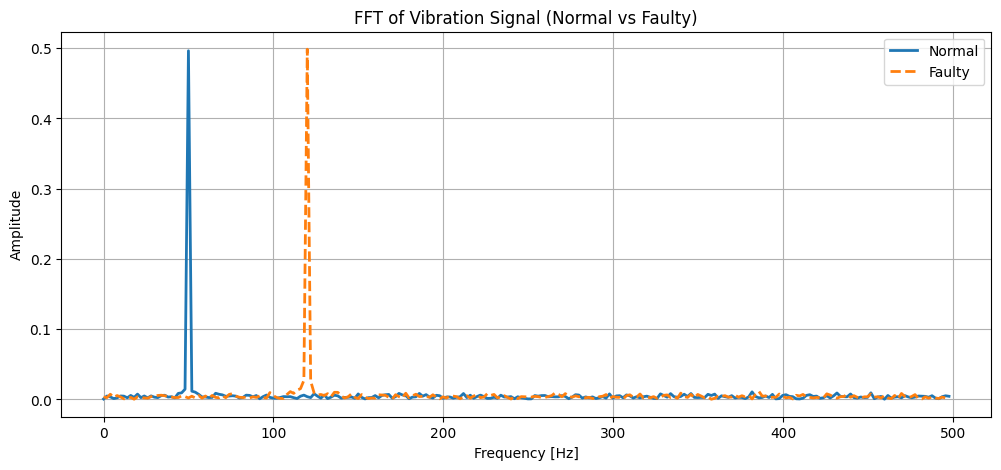

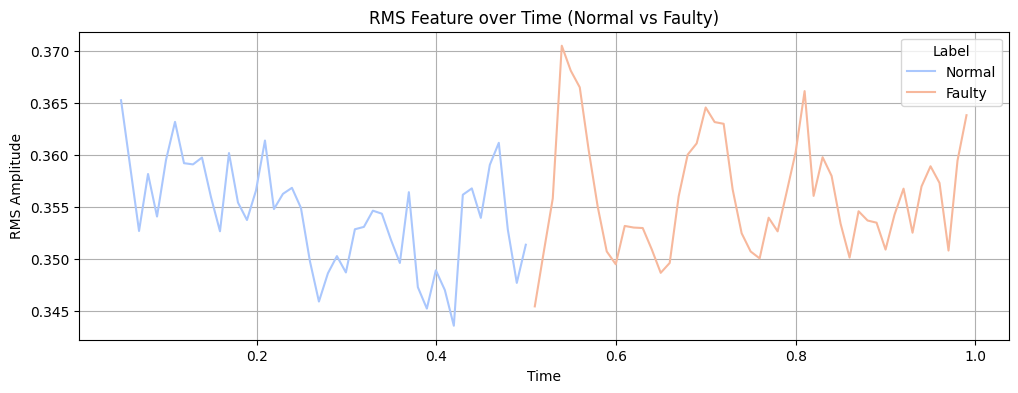

Epoch 1/30


/Users/rajkumarmyakala/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6912 - loss: 0.6802 - val_accuracy: 0.5294 - val_loss: 0.6562
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5894 - loss: 0.6405 - val_accuracy: 0.6471 - val_loss: 0.6119
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7466 - loss: 0.5467 - val_accuracy: 0.7647 - val_loss: 0.5256
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9394 - loss: 0.4727 - val_accuracy: 1.0000 - val_loss: 0.3389
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9224 - loss: 0.3018 - val_accuracy: 1.0000 - val_loss: 0.1725
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9358 - loss: 0.1992 - val_accuracy: 1.0000 - val_loss: 0.0851
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9257 - loss: 0.1667 - val_accuracy: 1.0000 - val_loss: 0.0536
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9477 - loss: 0.1638 - val_accuracy: 0.8824 - val_loss: 0.1609
Epoch 9/30
9/9 ━━━

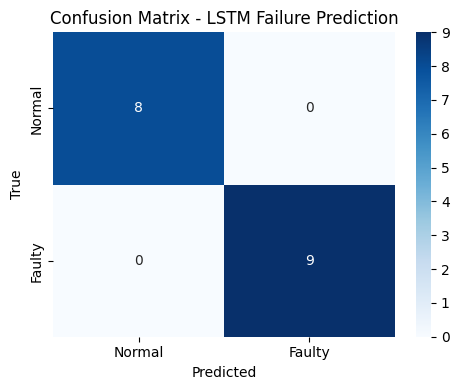

In [1]:

# Intelligent Failure Prediction in Rotating Machinery using LSTM

## 1. Imports and Simulate Vibration Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import seaborn as sns

np.random.seed(42)

time = np.linspace(0, 1, 1000)
freq_normal = 50
freq_faulty = 120

signal_normal = 0.5 * np.sin(2 * np.pi * freq_normal * time) + 0.05 * np.random.randn(len(time))
signal_faulty = 0.5 * np.sin(2 * np.pi * freq_faulty * time) + 0.05 * np.random.randn(len(time))

signal_combined = np.concatenate((signal_normal[:500], signal_faulty[500:]))

df_vibration = pd.DataFrame({
    'Time': time,
    'Vibration': signal_combined,
    'Label': ['Normal'] * 500 + ['Faulty'] * 500
})

plt.figure(figsize=(12, 4))
sns.lineplot(x='Time', y='Vibration', hue='Label', data=df_vibration, palette="coolwarm")
plt.title('Simulated Vibration Signal (Normal vs Faulty)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## 2. FFT Analysis
fft_normal = fft(signal_normal[:500])
fft_faulty = fft(signal_faulty[500:])

n = 500
freqs = np.fft.fftfreq(n, d=(time[1] - time[0]))[:n//2]
fft_mag_normal = 2.0 / n * np.abs(fft_normal[:n // 2])
fft_mag_faulty = 2.0 / n * np.abs(fft_faulty[:n // 2])

plt.figure(figsize=(12, 5))
plt.plot(freqs, fft_mag_normal, label='Normal', linewidth=2)
plt.plot(freqs, fft_mag_faulty, label='Faulty', linewidth=2, linestyle='--')
plt.title('FFT of Vibration Signal (Normal vs Faulty)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

## 3. Feature Extraction (Rolling Window)
window_size = 50
step_size = 10
features = []

for start in range(0, len(df_vibration) - window_size, step_size):
    end = start + window_size
    segment = df_vibration.iloc[start:end]
    window_time = segment['Time'].values[-1]
    rms = np.sqrt(np.mean(segment['Vibration']**2))
    kurtosis = segment['Vibration'].kurt()
    peak_to_peak = segment['Vibration'].max() - segment['Vibration'].min()
    mean = segment['Vibration'].mean()
    std = segment['Vibration'].std()
    label = segment['Label'].values[-1]
    features.append({
        'Time': window_time,
        'RMS': rms,
        'Kurtosis': kurtosis,
        'PeakToPeak': peak_to_peak,
        'Mean': mean,
        'STD': std,
        'Label': label
    })

df_features = pd.DataFrame(features)

plt.figure(figsize=(12, 4))
sns.lineplot(data=df_features, x='Time', y='RMS', hue='Label', palette="coolwarm")
plt.title('RMS Feature over Time (Normal vs Faulty)')
plt.xlabel('Time')
plt.ylabel('RMS Amplitude')
plt.grid(True)
plt.show()

## 4. LSTM Sequence Preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

feature_cols = ['RMS', 'Kurtosis', 'PeakToPeak', 'Mean', 'STD']
X = df_features[feature_cols].values
y = df_features['Label'].map({'Normal': 0, 'Faulty': 1}).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

lookback = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - lookback):
    X_seq.append(X_scaled[i:i+lookback])
    y_seq.append(y[i+lookback])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

## 5. Train LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test), verbose=1)

## 6. Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Faulty"], yticklabels=["Normal", "Faulty"])
plt.title('Confusion Matrix - LSTM Failure Prediction')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


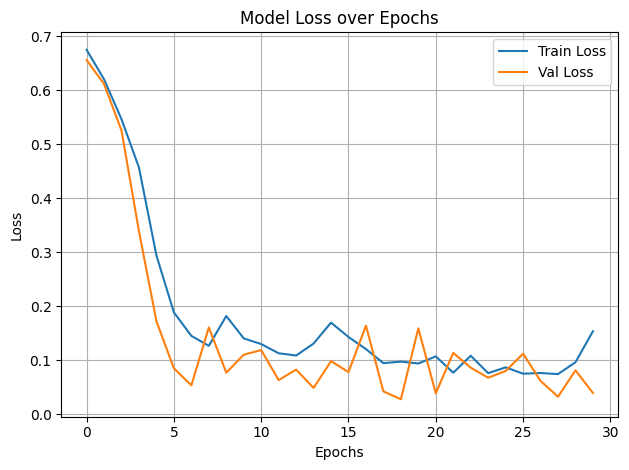

In [2]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


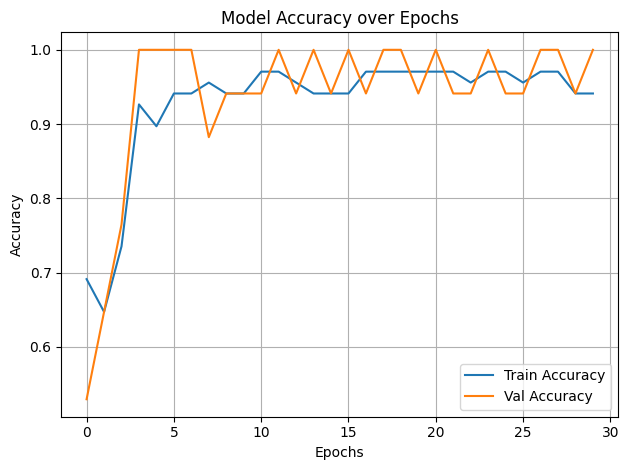

In [3]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

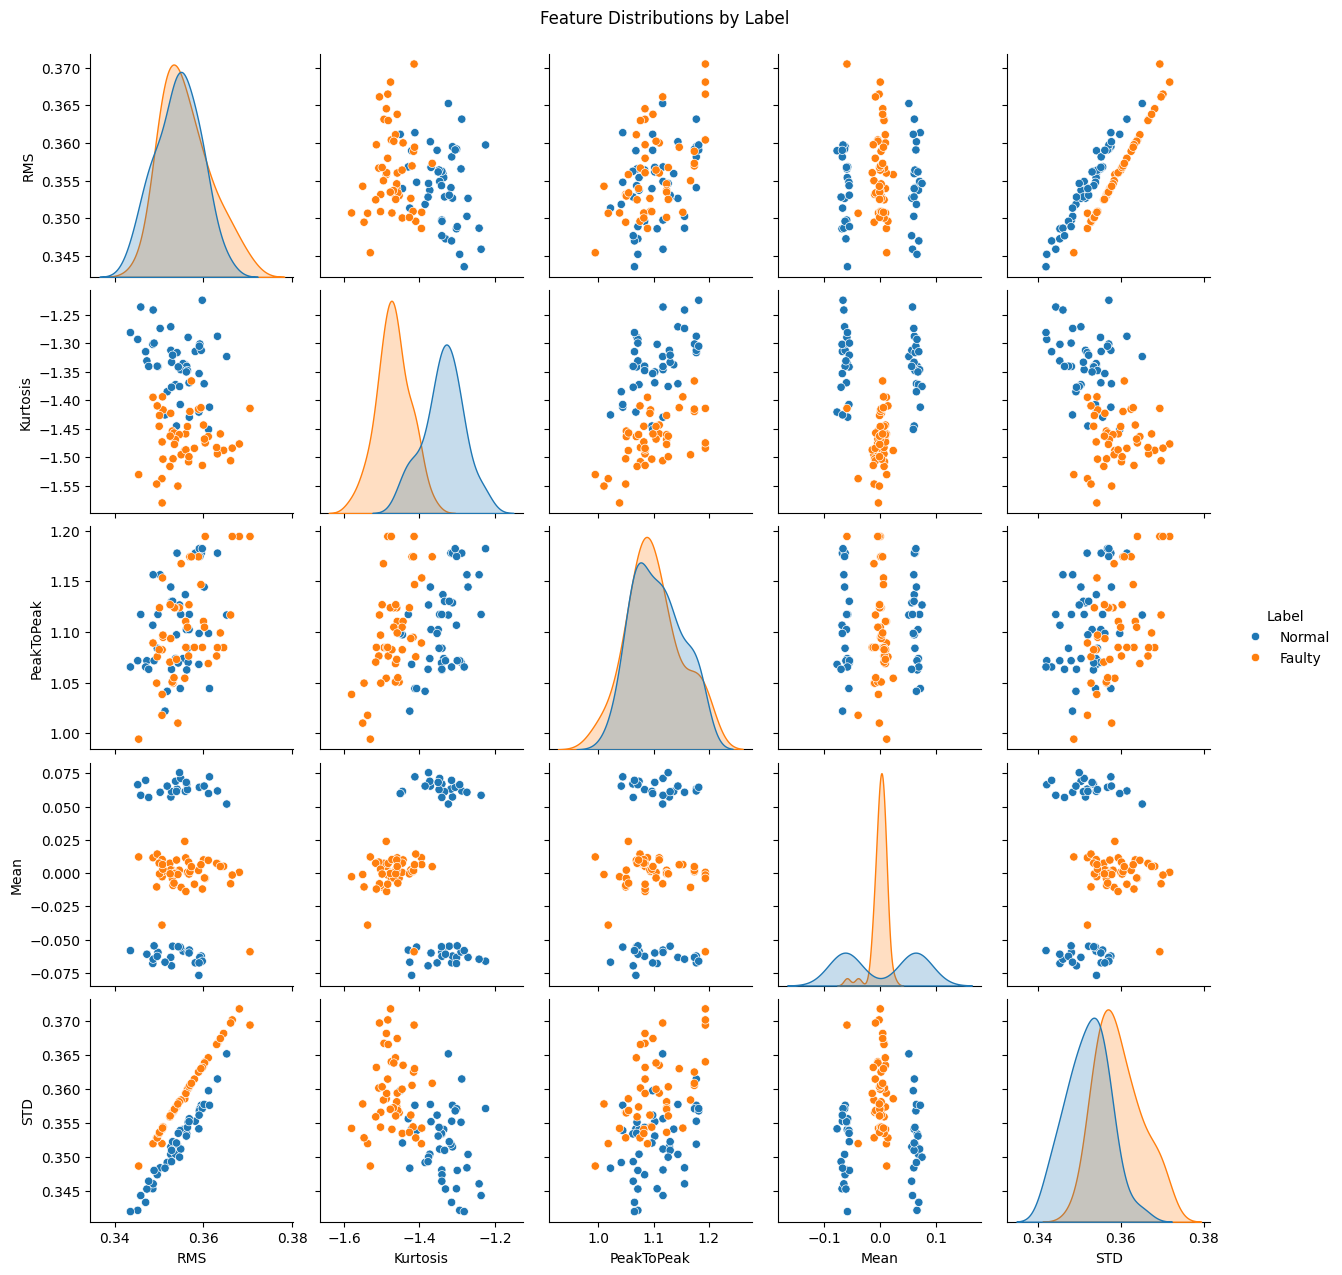

In [4]:
sns.pairplot(df_features, hue="Label", vars=["RMS", "Kurtosis", "PeakToPeak", "Mean", "STD"])
plt.suptitle("Feature Distributions by Label", y=1.02)
plt.show()


In [5]:
# Save the model
model.save('lstm_failure_prediction_model.h5')
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_failure_prediction_model.h5')
# Predict using the loaded model
predictions = loaded_model.predict(X_test)
predictions = (predictions > 0.5).astype("int32").flatten()
# Display predictions
print("Predictions from loaded model:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predictions from loaded model: [1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0]
